In [1]:
from gym import envs
envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [2]:
import gym
env = gym.make('CartPole-v0')

In [3]:
state1 = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)

In [5]:
import gym
import numpy as np
import torch

l1 = 4
l2 = 150
l3 = 2
# 입력으론 4개 값이 들어가고
# 히든층엔 150개의 노드로 구성되어 있고,
# 2차원 출력값을 반환한다.

model = torch.nn.Sequential(
    torch.nn.Linear(l1,l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2,l3),
    torch.nn.Softmax()
)
# 출력값이 2개(좌이동 우이동)로 나뉘어지기 때문에 Softmax 를 쓴다.
# 그리고 임계값 기준 구분을 하기 위해 LeakyReLU 를 중간에 넣어준다.

learning_rate = 0.0009
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# 학습율을 0.0009 로 하고,
# 최적화기에 모델의 매개변수들을 넣고, lr 의 학습율로 최적화시킨다.

In [10]:
def discount_rewards(rewards, gamma=0.99):
  lenr = len(rewards)
  disc_return = torch.pow(gamma, torch.arange(lenr).float())*rewards
  disc_return /= disc_return.max()
  return disc_return

In [11]:
# 손실함수
def loss_fn(preds, r):
  return -1*torch.sum(r*torch.log(preds))

In [12]:
# REINFORCE 훈련 루프
MAX_DUR = 200
MAX_EPISODES = 500
gamme = 0.99
score = []
for episode in range(MAX_EPISODES):
  curr_state = env.reset()
  done = False
  transitions = []

  for t in range(MAX_DUR):# 최대 200초까지 게임 진행
    act_prob = model(torch.from_numpy(curr_state).float())
    # 행동 확률분포를 산출한다
    action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy())
    # 확률분포를 기준으로 행동을 선택한다.
    prev_state = curr_state
    # 이전 상태를 저장한다.
    curr_state, _, done, info = env.step(action)
    # 새 상태로 갱신한다.
    transitions.append((prev_state,action,t+1)) # 이전 상태, 이전 행동, 시간
    if done:
      break

  ep_len = len(transitions)
  # 에피소드 길이를 기록 (길이가 길 수록 가치가 높은 것)
  score.append(ep_len)
  # 점수가 곧 에피소드의 길이가 된다.
  reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,))
  # 보상들을 담는다.
  disc_rewards = discount_rewards(reward_batch)
  # 할인율을 적용한다.
  state_batch = torch.Tensor([s for (s,a,r) in transitions])
  # 상태들을 담는다
  action_batch = torch.Tensor([a for (s,a,r) in transitions])
  # 행동들을 담는다
  pred_batch = model(state_batch)
  # 예측 기대값들을 담는다
  prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()
  # 확률분포를 담는다 (action - 확률 로 이루어진 ndarray 였는데, 거기서 action을 없앤다) - 확률만 남음
  loss = loss_fn(prob_batch, disc_rewards)
  # 해당 행동을 선택할 확률과 할인된 보상을 곱하고,
  # 거기다 -1을 곱해서 손실 함수를 구한다.
  optimizer.zero_grad()
  # 최적화기를 초기화해준다.
  loss.backward()
  # 손실함수를 이용해 역전파를 행한다.
  optimizer.step()
  # 그리고 매개변수를 갱신한다.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Text(0, 0.5, 'score')

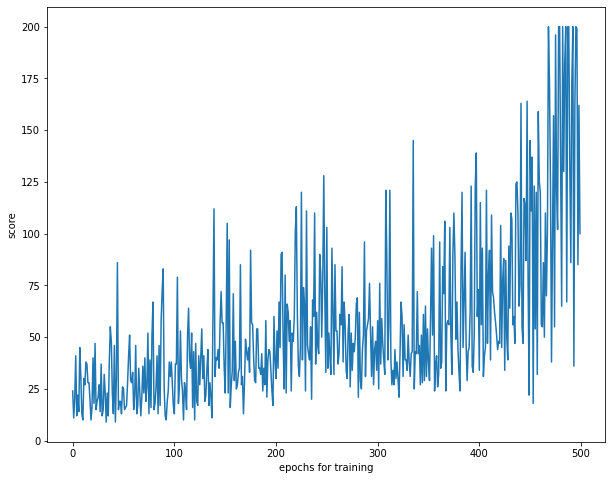

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(score)
plt.xlabel('epochs for training')
plt.ylabel('score')


In [18]:
# REINFORCE 는 정책 함수를 효과적으로 손쉽게 훈련하는 방법이다. 
# 하지만 상태공간이 작고 동작의 수도 아주 적은 간단한 곳에서만 적용가능하다는 단점을 가진다.
# 그럼 동작이 많으면 어떨까?
# 더 정교한 방법들을 공부해보자.

In [20]:
# 단어 정리
# 확률 : 서로 다른 결과들에 대한 확신도를 배정하는 수단이다.
# 확률분포 : 가능한 결과들에 배정한 확률들 전체를 특징짓는 수단이다. 0~1 사이로 사상된다.
# 퇴화확률분포 : 항상 특정한 결과 하나만 추출되는 확률분포이다.
# 조건부 확률 : 추가적인 정보가 주어졌을 때 결과의 확률
# 정책 : 상태를 동작으로 사상하는 함수 pi : S->A
# 수익 : 하나의 에피소드 전체에 대해 환경이 제공한 보상들을 적절히 할인해서 합한 값이다.
# 정책기울기방법 : 매개변수화된 함수를 정책함수로 사용해서 정책을 직접 배우는 방식이다.
# REINFORCE 알고리즘 : PG(정책기울기 방법)의 가장 간단한 예이다.